In [24]:
import cv2
import ezc3d
import numpy as np
import json
import matplotlib.pyplot as plt

In [17]:
VID = "/home/rjaikanth97/myspace/dissertation-final/dissertation/dataset/aspset/trainval/videos/4d9e/4d9e-0006-left.mkv"
BOX = "/home/rjaikanth97/myspace/dissertation-final/dissertation/dataset/aspset/trainval/boxes/4d9e/4d9e-0006-left.csv"
CAM = "/home/rjaikanth97/myspace/dissertation-final/dissertation/dataset/aspset/trainval/cameras/4d9e/4d9e-left.json"
JNT = "/home/rjaikanth97/myspace/dissertation-final/dissertation/dataset/aspset/trainval/joints_3d/4d9e/4d9e-0006.c3d"


In [25]:
"""
dissertation.c3d.py
Author: Raghhuveer Jaikanth
Date  : 17/07/2023

Utility functions for c3d files
"""
import json
import os
from dataclasses import dataclass

import ezc3d
import numpy as np


@dataclass
class Mocap:
    joint_positions: np.ndarray
    skeleton_name: str
    sample_rate: float


def load_mocap(filename: str):
    c3d = ezc3d.c3d(os.fspath(filename))
    sample_rate = c3d['parameters']['POINT']['RATE']['value'][0]
    skeleton_name = c3d['parameters']['POINT']['SKEL']['value'][0]
    joints = c3d['data']['points'].transpose(2, 1, 0)[..., :3].astype(np.float32)
    return Mocap(joints, skeleton_name, sample_rate)


def get_projection_matrix(filename: str):
    with open(filename, 'r') as f:
        cam_json = json.load(f)

    int_mat = np.asarray(cam_json["intrinsic_matrix"]).reshape([3, 4])
    ext_mat = np.asarray(cam_json["extrinsic_matrix"]).reshape([4, 4])
    return int_mat @ ext_mat


def to_homogeneous(points):
    """Cartesian to homogeneous"""
    return np.concatenate([points, np.ones_like(points[..., -1:])], -1)


def ensure_homogeneous(points, d):
    if points.shape[-1] == d + 1:
        return points
    assert points.shape[-1] == d
    return to_homogeneous(points)


def to_cartesian(points):
    return points[..., :-1] / points[..., -1:]


def extract_2d_from_c3d(c3d_file: str, camera_file: str):
    camera_matrix = get_projection_matrix(camera_file)
    c3d_obj = load_mocap(c3d_file)

    return to_cartesian(ensure_homogeneous(c3d_obj.joint_positions, 3) @ camera_matrix.T)

In [92]:
import pandas as pd

box = pd.read_csv(BOX)
cap = cv2.VideoCapture(VID)
joints = extract_2d_from_c3d(JNT, CAM)

import albumentations as A

category_id = [0]

transform = A.Compose([A.Resize(640, 640, p=1, always_apply=True)], keypoint_params=A.KeypointParams("xy"), bbox_params=A.BboxParams("pascal_voc"))
# bb_transform = A.Compose([A.Resize(640, 640, p=1, always_apply=True)], )

while True:
    ret, frame = cap.read()

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    joint = joints[0]
    bbox  = box.iloc[0, :].values.tolist()
    bbox.append("Person")
    # print(bbox.shape, joints.shape)

    transformed = transform(image=frame, keypoints=joint, bboxes=[bbox])
    # bb_transformed = bb_transform(image=frame, bboxes=[bbox])

    # print(bb_transformed['bboxes'])
    # print(kp_transformed['keypoints'])
    frame = transformed['image']
    joint = np.asarray(transformed['keypoints'])
    bbox  = np.asarray(transformed['bboxes'][0][:-1], dtype=int)
    print(bbox.shape)

    # plt.imshow(frame)
    # plt.scatter(bbox[:, 0], bbox[:, 1], c='blue', s=20)
    # plt.scatter(joint[:-1, 0], joint[:-1, 1], c='red', s=5)
    # plt.show()


    break

    if not ret:
        break


(4,)


In [89]:
def xyxy2xwyhn(xyxy, w, h):
    x = ((xyxy[0] + xyxy[2]) / 2) / w
    y = ((xyxy[1] + xyxy[3]) / 2) / h
    w = (xyxy[2] - xyxy[0]) / w
    h = (xyxy[3] - xyxy[1]) / h
    return np.asarray([x, y, w, h])

def xywhn2xyxy(xywh, w, h):
    x, y, _w, _h = xywh
    x1 = w * (x - _w / 2)
    y1 = h * (y - _h / 2)
    x2 = w * (x + _w / 2)
    y2 = h * (y + _h / 2)
    return np.asarray([x1, y1, x2, y2])

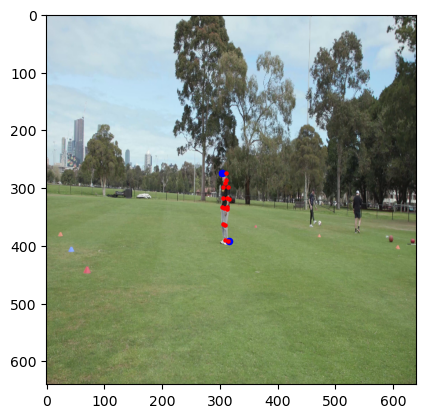

In [90]:
bbox = xywhn2xyxy(xyxy2xwyhn(bbox, 640, 640), 640, 640).reshape((2, 2))

plt.imshow(frame)
plt.scatter(bbox[:, 0], bbox[:, 1], c='blue', s=20)
plt.scatter(joint[:-1, 0], joint[:-1, 1], c='red', s=5)
plt.show()
